In [1]:
import scipy
import numpy as np
import matplotlib
from matplotlib import pyplot
from scipy.optimize import minimize 
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
numgenes = 10
numtfs = 5

alpha = np.array([1.0 for i in range(numgenes)])
beta = np.array([0.0 for i in range(numgenes)])
cs = np.random.rand(numgenes, numtfs)
tfa = np.random.rand(numtfs)

In [3]:
"""
Calculates the predicted gene expression values for the given parameters, assuming enhancers
"""
def getGeneExpression(alpha, beta, cs, tfa):
    return [beta[i] + (alpha[i]*sum([tfa[x] / (tfa[x] + cs[i][x]) for x in range(len(cs[0]))]))
            for i in range(len(cs))]

exprs = getGeneExpression(alpha, beta, cs, tfa)
print(exprs)

[2.097906701137743, 2.5840799587780445, 2.180878422800494, 2.3272884438502586, 2.096061407542675, 2.3454239254679847, 2.301286941620556, 2.7038257852845247, 2.199998292481863, 2.920255524357972]


In [4]:
"""
Calculates the error in the predicted gene expression values given the true values and the parameters
"""
def getErrorFromParameters(exprs, alpha, beta, cs, tfa):
    return sum(map(lambda x: (x[1] - x[0])**2, zip(getGeneExpression(alpha, beta, cs, tfa), exprs)))

In [5]:
"""
Calculates error given predicted and actual values
"""
def getError(exprs, pred):
    return sum(map(lambda x: (x[1] - x[0])**2, zip(pred, exprs)))

cs2 = np.random.rand(numgenes, numtfs)
tfa2 = np.random.rand(numgenes, numtfs)

# print(getErrorFromParameters(exprs, alpha, beta, cs2, tfa2))

In [6]:
"""
Calculates the predicted gene expression values for the given parameters, assuming enhancers
In addition, this simulates transcription factor at index tfdel is deleted, therefore setting
the activity of that transcription factor in the tfa matrix to zero
"""
def getGeneExpressionWithDeletion(alpha: np.array, beta: np.array, cs: np.array, tfa: np.array, tfdel: int):
    updatedtfa = tfa.copy()
    updatedtfa[tfdel] = 0.0
    return getGeneExpression(alpha, beta, cs, updatedtfa)

def getGeneExpressionWithDeletions(alpha: np.array, beta: np.array, cs: np.array, tfa: np.array, tfdels: list):
    updatedtfa = tfa.copy()
    for tfdel in tfdels: 
        updatedtfa[tfdel] = 0.0
    return getGeneExpression(alpha, beta, cs, updatedtfa)

def getGeneExpressionMatrixWithDeletion(alpha: np.array, beta: np.array, cs: np.array, tfa: np.array):
    return np.array([getGeneExpressionWithDeletion(alpha, beta, cs, tfa, i) for i in range(len(tfa))]).transpose()


In [7]:
"""
Calculates total error from matrix of gene expressions where column i is the expression vector for
the system with transcription factor i deleted. Thus this is a numgenes * numtfs matrix
"""
def getErrorWithDeletionsFromParameters(expr_matrix, alpha, beta, cs, tfa):
    pred_matrix = np.array([getGeneExpressionWithDeletion(alpha, beta, cs, tfa, i) for i in range(len(tfa))]).transpose()
    return np.square(pred_matrix - expr_matrix).sum()

In [8]:
"""
Calculates total error from matrix of gene expressions where column i is the expression vector for
the system with transcription factor i deleted. Thus this is a numgenes * numtfs matrix
"""
def getErrorWithDeletions(expr_matrix, pred_matrix):
    return np.square(pred_matrix - expr_matrix).sum()

In [9]:
del_exprs = getGeneExpressionMatrixWithDeletion(alpha, beta, cs, tfa)
csTFA = np.random.rand(numgenes + 1, numtfs)

In [10]:
"""
Splits csTFA (numgenes x 2*numtfs) into two numgenes x numtfs matricies, so that only the 
objective function needs to be rewritten to accomodate for a singular
csTFA matrix
"""
# def splitMat(csTFA):
#     """
#     For some reason, the minimize function turns csTFA into a
#     one-dimentional array and throws an exception. Fixed this with
#     try-except
#     """
#     try:
#         cs = np.array([csTFA[i][:numtfs] for i in range(numgenes)])
#         tfa = np.array([csTFA[i][numtfs:] for i in range(numgenes)])
#     except:
#         csTFA2 = []
#         for i in range(len(csTFA)):
#             if (i+1) % (2 * numtfs) == 0:
#                 csTFA2.append(csTFA[i-(2 * numtfs - 1):i+1])
#         #print(csTFA2)
#         cs = np.array([csTFA2[i][:numtfs] for i in range(numgenes)])
#         tfa = np.array([csTFA2[i][numtfs:] for i in range(numgenes)])
#     return cs, tfa

def splitMat(csTFA):
    """
    For some reason, the minimize function turns csTFA into a
    one-dimentional array and throws an exception. Fixed this with
    try-except
    """
    cs = csTFA[:numgenes]
    tfa = csTFA[numgenes:].reshape(-1)
    tfa = np.abs(tfa)
    return cs, tfa

# cs3, tfa3 = splitMat(csTFA)
# print(cs3, tfa3)

"""
This function and the following variable exprs2 are actually never called
(originally thoight they would be), but I'm leaving it in just in
case it could be useful in the future
"""
def GGE2(alpha, beta, csTFA):
    cs_l, tfa_l = splitMat(csTFA.reshape(numgenes + 1, numtfs))
    return getGeneExpression(alpha, beta, cs_l, tfa_l)
exprs2 = GGE2(alpha, beta, csTFA)


"""
Same general functionality as original function. csTFA taken as first
parameter for minimization. This is then split into cs and tfa, and 
at this point the function (and call stack) becomes exactly the same 
as getErrorWithDeletionsFromParameters()
"""
def GEWDFP2(csTFA, expr_matrix, alpha, beta):
    cs, tfa = splitMat(csTFA.reshape(numgenes + 1, numtfs))
    pred_matrix = np.array([getGeneExpressionWithDeletion(alpha, beta, cs, tfa, i) for i in range(len(tfa))]).transpose()
    return np.square(pred_matrix - expr_matrix).sum()

def GEWDFP2_with_LASSO(csTFA, expr_matrix, alpha, beta, l=1E-3):
    cs, tfa = splitMat(csTFA.reshape(numgenes + 1, numtfs))
    pred_matrix = np.array([getGeneExpressionWithDeletion(alpha, beta, cs, tfa, i) for i in range(len(tfa))]).transpose()
    err_term = np.square(pred_matrix - expr_matrix).sum()
    lasso_term = np.abs(csTFA).sum()
    return err_term + (l*lasso_term)

In [11]:
GEWDFP2(csTFA, del_exprs, alpha, beta)

15.451937975454646

In [12]:
minimize(GEWDFP2_with_LASSO, csTFA, args=(del_exprs, alpha, beta))

      fun: 0.014953214683871438
 hess_inv: array([[ 0.02263886,  0.0373084 ,  0.13009379, ...,  0.0830967 ,
         0.04960053, -0.06733907],
       [ 0.0373084 ,  2.78245756, -0.09629094, ..., -0.06350866,
        -0.20275064,  0.22785598],
       [ 0.13009379, -0.09629094,  2.08465537, ...,  1.040353  ,
         0.62976033, -0.85022746],
       ...,
       [ 0.0830967 , -0.06350866,  1.040353  , ...,  0.86913487,
         0.42823118, -0.68326218],
       [ 0.04960053, -0.20275064,  0.62976033, ...,  0.42823118,
         0.75974265, -0.53122768],
       [-0.06733907,  0.22785598, -0.85022746, ..., -0.68326218,
        -0.53122768,  0.8091856 ]])
      jac: array([ 9.07124821e+00,  2.53439392e-03,  2.93091347e-03,  4.00774773e-02,
        1.29395350e-02, -1.31971274e+01,  3.13712412e-03,  1.15196111e-02,
        1.18276519e-02, -3.61343008e-03,  1.47508872e+01,  1.55716785e-03,
        3.34164771e-02,  8.33148016e-02,  3.89978958e-02, -1.75313145e+01,
       -5.84918540e-03, -2.401639

In [13]:
alphaT = np.array([1.0 for i in range(numgenes)])
betaT = np.array([0.0 for i in range(numgenes)])
csTFAT = np.random.rand(1 + numgenes, numtfs)
csT, tfaT = splitMat(csTFAT)
exprsT = getGeneExpressionMatrixWithDeletion(alphaT, betaT, csT, tfaT)
res = minimize(GEWDFP2_with_LASSO, np.random.rand(1 + numgenes, numtfs), args=(exprsT, alphaT, betaT)).x

print(csTFAT)
print('-------------------------------------------------------')
print(res)

[[0.48597044 0.75277409 0.37844856 0.79276473 0.8627315 ]
 [0.99040915 0.76778096 0.74107204 0.61402122 0.70727574]
 [0.10438822 0.51711384 0.46739503 0.40717396 0.59706146]
 [0.1263076  0.41722314 0.80534877 0.60389428 0.20620055]
 [0.3537906  0.19101963 0.54324098 0.35646405 0.27712931]
 [0.04874806 0.57894979 0.40526581 0.01429108 0.35205801]
 [0.21980121 0.60619339 0.49797889 0.64871844 0.43703912]
 [0.60745303 0.53317115 0.92434246 0.87934791 0.95264661]
 [0.11980477 0.01455738 0.32657979 0.20009025 0.29594557]
 [0.35482075 0.05491049 0.48869385 0.34990002 0.87554725]
 [0.54479415 0.52113993 0.81706667 0.42363854 0.01504143]]
-------------------------------------------------------
[ 1.25735630e-01  5.12056748e-01  4.61349737e-04  3.01401465e-01
  1.33796592e+00  2.55956728e-01  5.17380681e-01  8.96977168e-04
  2.32369728e-01  3.62293941e-01  2.72666970e-02  3.57043169e-01
  5.74283008e-04  1.57378575e-01  2.73397191e-02  3.30603199e-02
  2.87828804e-01  9.93186712e-04  2.32770811e

In [14]:
#Other solvers
# dict value format : [objective function value, x value]
solvers = {
    'Nelder-Mead': [None,None],
    'Powell': [None,None],
    'CG': [None,None],
    'BFGS': [None,None],
    'L-BFGS-B': [None,None],
    'TNC': [None,None],
    'SLSQP': [None,None]
}
solversLasso = {
    'Nelder-Mead': [None,None],
    'Powell': [None,None],
    'CG': [None,None],
    'BFGS': [None,None],
    'L-BFGS-B': [None,None],
    'TNC': [None,None],
    'SLSQP': [None,None]
}

randGuess = np.random.rand(1 + numgenes, numtfs)
for solver in solvers.keys():
    try:
        print('===================================================================')
        print(f"{solver}: ")
        print('----------------------------WITH LASSO-----------------------------')
        lassoSolve = minimize(GEWDFP2_with_LASSO, randGuess, args=(exprsT, alphaT, betaT), method=solver)
        solversLasso[solver][0] = lassoSolve.fun
        solversLasso[solver][1] = lassoSolve.x
        print(f"Objective: {solversLasso[solver][0]}")
        print(solversLasso[solver][1])
        print('---------------------------WITHOUT LASSO---------------------------')
        noLassoSolve = minimize(GEWDFP2, randGuess, args=(exprsT, alphaT, betaT), method=solver)
        solvers[solver][0] = noLassoSolve.fun
        solvers[solver][1] = noLassoSolve.x
        print(f"Objective: {solvers[solver][0]}")
        print(solvers[solver][1])
        print('===================================================================')
    except ValueError as ve:
        solvers[solver] = str(ve)

Nelder-Mead: 
----------------------------WITH LASSO-----------------------------
Objective: 1.7336641447911354
[ 2.69131784e-01  4.94373292e-01  1.51815590e-02  1.08979052e+00
  1.48301108e-01  8.45269812e-01  2.19895092e-01  1.00534563e+00
  5.20318516e-01  9.27240571e-02  1.03380178e-02  2.36022324e-04
  1.10185849e+00  4.71747545e-01  6.44645577e-01  2.46276503e-01
  2.27546116e-01  2.10659733e-01  3.68695822e-01  2.35727915e+00
  3.96261925e-01  1.09611477e-01  5.14522855e-01  1.28780554e-01
  1.99943467e-01  6.91929750e-02  1.85768846e-01  8.34096578e-02
  9.60220050e-02  6.39217496e-01  1.36719228e-01  5.14066268e-01
  5.37739804e-02  9.54199576e-01  7.29807765e-01  3.12710673e-01
  2.21347740e-02  1.74194412e+00  1.17838529e+00  4.80843066e-01
  2.64610667e-02  1.04411155e-02  2.06724882e-01  2.00511396e-01
  6.69641232e-01  1.33510306e-01 -1.27277477e-03  2.60952728e-01
  1.51444094e+00  8.38378445e-02  4.17783430e-01  2.35775533e-01
  4.66666270e-01  3.68839312e-01 -3.8497412

In [15]:
#Running minimize results from solversLasso back through GEWDFP2

resolveLasso = {
    'Nelder-Mead': None,
    'Powell': None,
    'CG': None,
    'BFGS': None,
    'L-BFGS-B': None,
    'TNC': None,
    'SLSQP': None
}

for solver in resolveLasso.keys():
    resolveLasso[solver] = GEWDFP2(solversLasso[solver][1], exprsT, alphaT, betaT)
    print('===================================================================')
    print(f"{solver} with lasso resolved: {resolveLasso[solver]}")
    print(f"{solver} without lasso objective: {solvers[solver][0]}")

Nelder-Mead with lasso resolved: 1.7101765058865261
Nelder-Mead without lasso objective: 1.5703989021324352
Powell with lasso resolved: 0.003163441323336195
Powell without lasso objective: 0.005297222193113242
CG with lasso resolved: 2.6655533170677782e-05
CG without lasso objective: 3.4428400270819995e-08
BFGS with lasso resolved: 0.0017679017379954654
BFGS without lasso objective: 5.509661382037797e-12
L-BFGS-B with lasso resolved: 0.001663618503443184
L-BFGS-B without lasso objective: 4.08927790508028e-05
TNC with lasso resolved: 1.7897263399715808
TNC without lasso objective: 0.01673434538742092
SLSQP with lasso resolved: 0.0012990229449039484
SLSQP without lasso objective: 0.006538851857498541


In [16]:
def crossValidateWithMultipleDeletions(x):
    cs, tfa = splitMat(x.reshape(numgenes + 1, numtfs))
    arr = []
    for i in range(numtfs):
        for j in range(numtfs):
            if i != j:
                sserr = np.sum(np.square(np.array(getGeneExpressionWithDeletions(alphaT, betaT, csT, tfaT, (i,j))) - np.array(getGeneExpressionWithDeletions(alphaT, betaT, cs, tfa, (i,j)))))
                arr.append(sserr)
    return arr

In [17]:
# solver : [sum, array of values]
crossValidation = {
    'Nelder-Mead': [None,None],
    'Powell': [None,None],
    'CG': [None,None],
    'BFGS': [None,None],
    'L-BFGS-B': [None,None],
    'TNC': [None,None],
    'SLSQP': [None,None]
}

lassoCrossValidation = {
    'Nelder-Mead': [None,None],
    'Powell': [None,None],
    'CG': [None,None],
    'BFGS': [None,None],
    'L-BFGS-B': [None,None],
    'TNC': [None,None],
    'SLSQP': [None,None]
}

for solver in crossValidation.keys():
    print('===================================================================')
    print(f"{solver}: ")
    solverX = solvers[solver][1]
    solverLassoX = solversLasso[solver][1]
    crossValidation[solver][1] = crossValidateWithMultipleDeletions(solverX)
    crossValidation[solver][0] = sum(crossValidation[solver][1])
    lassoCrossValidation[solver][1] = crossValidateWithMultipleDeletions(solverLassoX)
    lassoCrossValidation[solver][0] = sum(lassoCrossValidation[solver][1])
    print(f"Sum of cross validation values: {crossValidation[solver][0]}")
    print(f"Sum of cross validation values with LASSO: {lassoCrossValidation[solver][0]}")

Nelder-Mead: 
Sum of cross validation values: 8.016430617032613
Sum of cross validation values with LASSO: 8.702682899431132
Powell: 
Sum of cross validation values: 0.03148097032347072
Sum of cross validation values with LASSO: 0.01872318543337119
CG: 
Sum of cross validation values: 2.0452524669404898e-07
Sum of cross validation values with LASSO: 0.000158294417556074
BFGS: 
Sum of cross validation values: 3.152609579109047e-11
Sum of cross validation values with LASSO: 0.010288894488741231
L-BFGS-B: 
Sum of cross validation values: 0.00024341528903399116
Sum of cross validation values with LASSO: 0.009834732476921165
TNC: 
Sum of cross validation values: 0.08854113198209412
Sum of cross validation values with LASSO: 10.244929691067222
SLSQP: 
Sum of cross validation values: 0.03880155688380799
Sum of cross validation values with LASSO: 0.007273408115960068


In [18]:
"""
Running through everything again, this time with Gaussian noise added to exprsT
"""

exprsTWithNoise = exprsT + np.random.normal(0, 0.01)

solversWithNoise = {
    'Nelder-Mead': [None,None],
    'Powell': [None,None],
    'CG': [None,None],
    'BFGS': [None,None],
    'L-BFGS-B': [None,None],
    'TNC': [None,None],
    'SLSQP': [None,None]
}
solversLassoWithNoise = {
    'Nelder-Mead': [None,None],
    'Powell': [None,None],
    'CG': [None,None],
    'BFGS': [None,None],
    'L-BFGS-B': [None,None],
    'TNC': [None,None],
    'SLSQP': [None,None]
}

print('SOLVING WITH ADDITIONAL GAUSSIAN NOISE')
randGuess = np.random.rand(1 + numgenes, numtfs)
for solver in solversWithNoise.keys():
    try:
        print('===================================================================')
        print(f"{solver}: ")
        print('----------------------------WITH LASSO-----------------------------')
        lassoSolve = minimize(GEWDFP2_with_LASSO, randGuess, args=(exprsTWithNoise, alphaT, betaT), method=solver)
        solversLassoWithNoise[solver][0] = lassoSolve.fun
        solversLassoWithNoise[solver][1] = lassoSolve.x
        print(f"Objective: {solversLassoWithNoise[solver][0]}")
        print(solversLassoWithNoise[solver][1])
        print('---------------------------WITHOUT LASSO---------------------------')
        noLassoSolve = minimize(GEWDFP2, randGuess, args=(exprsTWithNoise, alphaT, betaT), method=solver)
        solversWithNoise[solver][0] = noLassoSolve.fun
        solversWithNoise[solver][1] = noLassoSolve.x
        print(f"Objective: {solversWithNoise[solver][0]}")
        print(solversWithNoise[solver][1])
        print('===================================================================')
    except ValueError as ve:
        solversWithNoise[solver] = str(ve)
        

SOLVING WITH ADDITIONAL GAUSSIAN NOISE
Nelder-Mead: 
----------------------------WITH LASSO-----------------------------
Objective: 0.8870414858424728
[ 3.51844211e-01  1.87001954e-01  3.48691386e-01  1.32420221e+00
  4.50169376e-01  3.34814659e-01  9.05746460e-01  6.11055351e-01
  2.38829674e-01  4.66027214e-01  1.43022848e-01  1.68882316e-01
  3.38945662e-01  2.68396451e-01  3.59833582e-01  1.02178546e-01
  1.80700672e-01  5.73158971e-01  3.13444962e-01  4.12755964e-01
  4.52543941e-01  1.15232444e-01  9.32726055e-01  4.06667191e-03
  4.68603911e-01  8.21106425e-02  3.58184147e-01  5.04730878e-04
  4.10565956e-02  2.62299160e+00  1.83367233e-01  3.75558057e-01
  3.77952348e-01  3.42441591e-01  1.33029628e-01  2.15925710e+00
  7.56140752e-02  4.13237412e-01  9.92932517e-01  6.94352665e-01
  1.88211219e-01 -1.12493530e-02  2.63260733e-01  1.09909326e-01
  5.22496024e-01  3.58237314e-01  1.45539459e-02  4.80972668e-01
  1.74756797e-01  1.54364816e+00  4.91471182e-01  2.03108613e-01
  5.

In [19]:
resolveLassoWithNoise = {
    'Nelder-Mead': None,
    'Powell': None,
    'CG': None,
    'BFGS': None,
    'L-BFGS-B': None,
    'TNC': None,
    'SLSQP': None
}

for solver in resolveLassoWithNoise.keys():
    resolveLassoWithNoise[solver] = GEWDFP2(solversLassoWithNoise[solver][1], exprsTWithNoise, alphaT, betaT)
    print('===================================================================')
    print(f"{solver} with lasso resolved: {resolveLassoWithNoise[solver]}")
    print(f"{solver} without lasso objective: {solversWithNoise[solver][0]}")
print('===================================================================')

crossValidationWithNoise = {
    'Nelder-Mead': [None,None],
    'Powell': [None,None],
    'CG': [None,None],
    'BFGS': [None,None],
    'L-BFGS-B': [None,None],
    'TNC': [None,None],
    'SLSQP': [None,None]
}

lassoCrossValidationWithNoise = {
    'Nelder-Mead': [None,None],
    'Powell': [None,None],
    'CG': [None,None],
    'BFGS': [None,None],
    'L-BFGS-B': [None,None],
    'TNC': [None,None],
    'SLSQP': [None,None]
}


for solver in crossValidationWithNoise.keys():
    print('===================================================================')
    print(f"{solver}: ")
    solverX = solversWithNoise[solver][1]
    solverLassoX = solversLassoWithNoise[solver][1]
    crossValidationWithNoise[solver][1] = crossValidateWithMultipleDeletions(solverX)
    crossValidationWithNoise[solver][0] = sum(crossValidationWithNoise[solver][1])
    lassoCrossValidationWithNoise[solver][1] = crossValidateWithMultipleDeletions(solverLassoX)
    lassoCrossValidationWithNoise[solver][0] = sum(lassoCrossValidationWithNoise[solver][1])
    print(f"Sum of cross validation values: {crossValidationWithNoise[solver][0]}")
    print(f"Sum of cross validation values with LASSO: {lassoCrossValidationWithNoise[solver][0]}")

Nelder-Mead with lasso resolved: 0.8629204340723756
Nelder-Mead without lasso objective: 0.6637197146835394
Powell with lasso resolved: 7.139288486881902e-05
Powell without lasso objective: 0.005797117534417672
CG with lasso resolved: 5.2972201786407753e-05
CG without lasso objective: 8.458132431419077e-08
BFGS with lasso resolved: 0.0019360604921272668
BFGS without lasso objective: 9.971838731695975e-08
L-BFGS-B with lasso resolved: 0.002553076321041549
L-BFGS-B without lasso objective: 3.776330760208066e-05
TNC with lasso resolved: 0.030081364097197007
TNC without lasso objective: 0.2035561277025925
SLSQP with lasso resolved: 0.002307526086373116
SLSQP without lasso objective: 0.0023274098840273434
Nelder-Mead: 
Sum of cross validation values: 3.939524857429896
Sum of cross validation values with LASSO: 4.921172669963654
Powell: 
Sum of cross validation values: 0.03605650771197506
Sum of cross validation values with LASSO: 0.0012640800073289663
CG: 
Sum of cross validation values: 0.

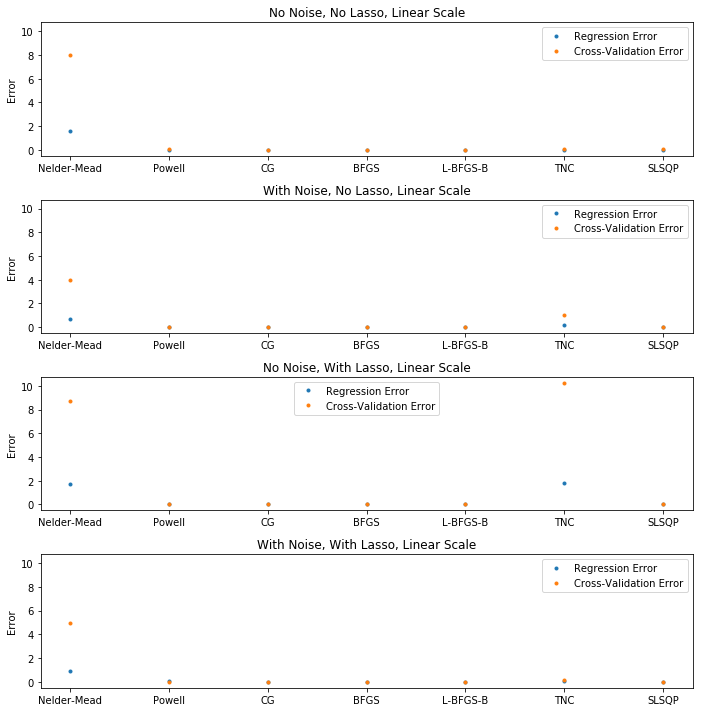

In [27]:
solversRegError = [solvers[solver][0] for solver in solvers.keys()]
solversCrossValError = [crossValidation[solver][0] for solver in solvers.keys()]

row0 = [solversRegError, solversCrossValError]

solversRegErrorWithNoise = [solversWithNoise[solver][0] for solver in solvers.keys()]
solversCrossValErrorWithNoise = [crossValidationWithNoise[solver][0] for solver in solvers.keys()]

row1 = [solversRegErrorWithNoise, solversCrossValErrorWithNoise]

solversLassoRegError = [solversLasso[solver][0] for solver in solvers.keys()]
solversLassoCrossValError = [lassoCrossValidation[solver][0] for solver in solvers.keys()]

row2 = [solversLassoRegError, solversLassoCrossValError]

solversLassoRegErrorWithNoise = [solversLassoWithNoise[solver][0] for solver in solvers.keys()]
solversLassoCrossValErrorWithNoise = [lassoCrossValidationWithNoise[solver][0] for solver in solvers.keys()]

row3 = [solversLassoRegErrorWithNoise, solversLassoCrossValErrorWithNoise]


rows = [row0, row1, row2, row3]
labels = ["Regression Error", "Cross-Validation Error"]
titles = ["No Noise, No Lasso, {}", "With Noise, No Lasso, {}", "No Noise, With Lasso, {}", "With Noise, With Lasso, {}"]
lin = "Linear Scale"
lg = "Logarithmc Scale"

solverList = list(solvers.keys())

fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize=(10,10), sharey=True)
for i in range(len(rows)):
    ax[i].plot(solverList, rows[i][0], label=labels[0], marker='.', linestyle='none')
    ax[i].plot(solverList, rows[i][1], label=labels[1], marker='.', linestyle='none')
    ax[i].legend()
    ax[i].set_ylabel('Error')
    ax[i].set_title(titles[i].format(lin))
plt.tight_layout()
plt.savefig("linearPlot.png")

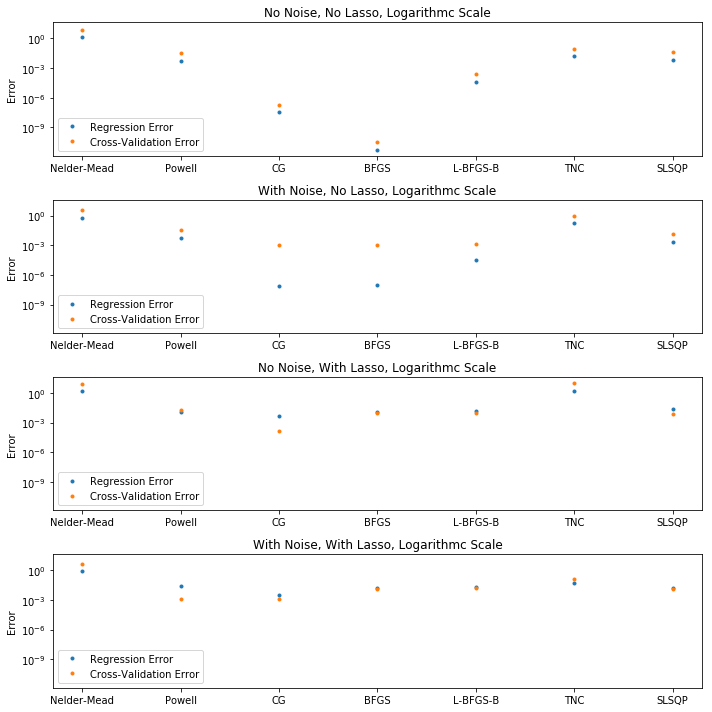

In [28]:
fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize=(10,10), sharey=True)
for i in range(len(rows)):
    ax[i].plot(solverList, rows[i][0], label=labels[0], marker='.', linestyle='none')
    ax[i].plot(solverList, rows[i][1], label=labels[1], marker='.', linestyle='none')
    ax[i].legend()
    ax[i].set_ylabel('Error')
    ax[i].set_title(titles[i].format(lg))
    ax[i].set_yscale("log")
plt.tight_layout()
plt.savefig("logPlot.png")

In [23]:
allSolvers = [
    solversRegError,
    solversCrossValError,
    solversRegErrorWithNoise,
    solversCrossValErrorWithNoise,
    solversLassoRegError,
    solversLassoCrossValError,
    solversLassoRegErrorWithNoise,
    solversLassoCrossValErrorWithNoise
]

solverInds = [
    "Regression Error, No Noise, No Lasso",
    "Cross-Validation Error, No Noise, No Lasso",
    "Regression Error, With Noise, No Lasso",
    "Cross-Validation Error, With Noise, No Lasso",
    "Regression Error, No Noise, With Lasso",
    "Cross-Validation Error, No Noise, With Lasso",
    "Regression Error, With Noise, With Lasso",
    "Cross-Validation Error, With Noise, With Lasso"
]

dfData = {solver: [allSolvers[j][i] for j in range(len(allSolvers))] for i,solver in enumerate(solvers.keys())}
df = pd.DataFrame(dfData, index=solverInds)
df

,Nelder-Mead,Powell,CG,BFGS,L-BFGS-B,TNC,SLSQP
"Regression Error, No Noise, No Lasso",1.570399,0.005297,3.442840e-08,5.509661e-12,0.000041,0.016734,0.006539
"Cross-Validation Error, No Noise, No Lasso",8.016431,0.031481,2.045252e-07,3.152610e-11,0.000243,0.088541,0.038802
"Regression Error, With Noise, No Lasso",0.663720,0.005797,8.458132e-08,9.971839e-08,0.000038,0.203556,0.002327
"Cross-Validation Error, With Noise, No Lasso",3.939525,0.036057,1.065899e-03,1.066311e-03,0.001363,1.050634,0.014795
"Regression Error, No Noise, With Lasso",1.733664,0.012525,4.951642e-03,1.338924e-02,0.014795,1.809919,0.022748
"Cross-Validation Error, No Noise, With Lasso",8.702683,0.018723,1.582944e-04,1.028889e-02,0.009835,10.244930,0.007273
"Regression Error, With Noise, With Lasso",0.887041,0.029083,3.474896e-03,1.614842e-02,0.019201,0.053610,0.014834
"Cross-Validation Error, With Noise, With Lasso",4.921173,0.001264,1.409979e-03,1.214882e-02,0.016386,0.128326,0.014611


In [25]:
print(df.to_latex(bold_rows=True))

\begin{tabular}{lrrrrrrr}
\toprule
{} &  Nelder-Mead &    Powell &            CG &          BFGS &  L-BFGS-B &        TNC &     SLSQP \\
\midrule
\textbf{Regression Error, No Noise, No Lasso          } &     1.570399 &  0.005297 &  3.442840e-08 &  5.509661e-12 &  0.000041 &   0.016734 &  0.006539 \\
\textbf{Cross-Validation Error, No Noise, No Lasso    } &     8.016431 &  0.031481 &  2.045252e-07 &  3.152610e-11 &  0.000243 &   0.088541 &  0.038802 \\
\textbf{Regression Error, With Noise, No Lasso        } &     0.663720 &  0.005797 &  8.458132e-08 &  9.971839e-08 &  0.000038 &   0.203556 &  0.002327 \\
\textbf{Cross-Validation Error, With Noise, No Lasso  } &     3.939525 &  0.036057 &  1.065899e-03 &  1.066311e-03 &  0.001363 &   1.050634 &  0.014795 \\
\textbf{Regression Error, No Noise, With Lasso        } &     1.733664 &  0.012525 &  4.951642e-03 &  1.338924e-02 &  0.014795 &   1.809919 &  0.022748 \\
\textbf{Cross-Validation Error, No Noise, With Lasso  } &     8.702683 &  0.018

In [ ]:
#added regularization term using LASSO constraint
#to mimic a biological system, added gaussian noise with a mean of 0 and standard deviation of .01